In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mazenatefmohamed
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict

captions_path = '/content/flickr8k/captions.txt'
images_dir = '/content/flickr8k/Images'

# Read the captions file
with open(captions_path, 'r') as f:
    captions = f.readlines()

# Remove the header line
captions = captions[1:]


In [ ]:
import os
import json


# Dictionary to keep only the first caption for each image
image_caption_map = {}

for line in captions:
    line = line.strip()
    if not line:
        continue
    image_name, caption = line.split(',', 1)
    image_name = image_name.split('#')[0].strip()  # Remove #0, #1 etc.
    if image_name not in image_caption_map:
        image_path = os.path.join(images_dir, image_name)
        image_caption_map[image_name] = {
            "image": image_path,
            "caption": caption.strip()
        }

# Convert to the required list format
final_data = list(image_caption_map.values())

# Optional: Print first few entries
for entry in final_data[:5]:
    print(entry)


{'image': '/content/flickr8k/Images/1000268201_693b08cb0e.jpg', 'caption': 'A child in a pink dress is climbing up a set of stairs in an entry way .'}
{'image': '/content/flickr8k/Images/1001773457_577c3a7d70.jpg', 'caption': 'A black dog and a spotted dog are fighting'}
{'image': '/content/flickr8k/Images/1002674143_1b742ab4b8.jpg', 'caption': 'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .'}
{'image': '/content/flickr8k/Images/1003163366_44323f5815.jpg', 'caption': 'A man lays on a bench while his dog sits by him .'}
{'image': '/content/flickr8k/Images/1007129816_e794419615.jpg', 'caption': 'A man in an orange hat starring at something .'}


In [ ]:
print(len(final_data))

8091


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import cv2

def display_image_with_caption(data_entry):
    image_path = data_entry["image"]
    caption = data_entry["caption"]

    # Read and convert image (from BGR to RGB)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Couldn't load image from path: {image_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display image with caption
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(caption, fontsize=12)
    plt.axis('off')
    plt.show()

In [ ]:
from transformers import pipeline

# Load the pipeline
pipe = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [ ]:
# Run the pipeline on the image
# result = pipe("R.jpg")
result = pipe(final_data[1598]['image'])

# Print the result
print(result[0]['generated_text'])

a boy playing baseball


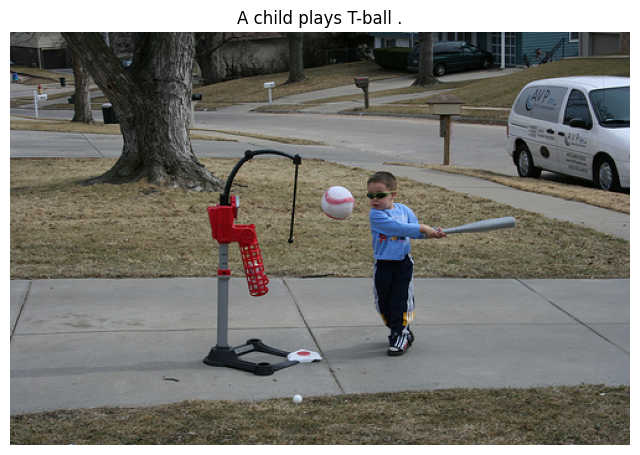

In [ ]:
display_image_with_caption(final_data[1598])

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer

# Load the processor and model for image captioning using BLIP
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration, TrainingArguments, Trainer
from PIL import Image
from torch.utils.data import Dataset
import torch
import os
import random

# Disable Weights and Biases logging
os.environ["WANDB_DISABLED"] = "true"

# Load the processor and base BLIP model for image captioning
model_name = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name)

# Custom dataset class for image-caption pairs
class CaptionDataset(Dataset):
    def __init__(self, data, processor):
        self.data = data
        self.processor = processor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = Image.open(item["image"]).convert("RGB")  # Load and convert image to RGB
        caption = item["caption"]

        # Preprocess the image and caption using the processor
        inputs = self.processor(
            images=image,
            text=caption,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=128
        )

        return {
            "pixel_values": inputs["pixel_values"].squeeze(),  # Image tensor
            "input_ids": inputs["input_ids"].squeeze(),        # Tokenized caption
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": inputs["input_ids"].squeeze()            # Labels are same as input_ids for captioning
        }

# Randomly sample 500 items from final_data for training
sampled_data = random.sample(final_data, 500)

# Create the dataset using the sampled data
train_dataset = CaptionDataset(sampled_data, processor)


Step,Training Loss
10,8.839100
20,7.041800
30,6.135100
40,5.171000
50,4.390400
60,3.604700
70,2.998200
80,2.511000
90,2.130600
100,1.850100


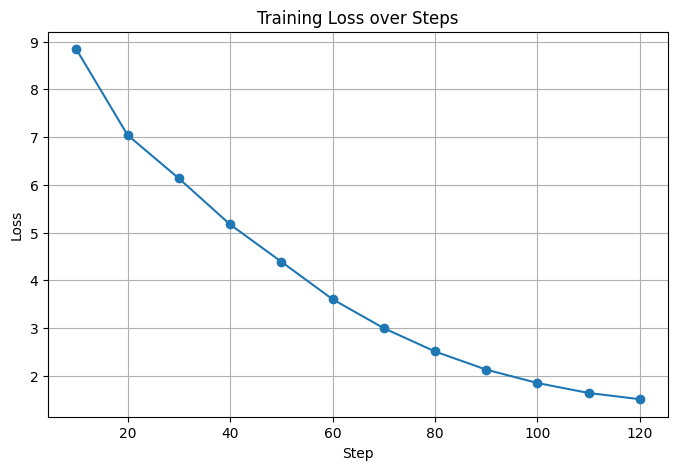

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBlipModel: ['text_decoder.bert.encoder.layer.8.attention.self.query.bias', 'text_decoder.bert.encoder.layer.4.crossattention.self.query.weight', 'text_decoder.bert.encoder.layer.5.crossattention.output.dense.weight', 'text_decoder.bert.encoder.layer.0.output.dense.bias', 'text_decoder.bert.encoder.layer.5.output.LayerNorm.weight', 'text_decoder.bert.encoder.layer.9.attention.self.value.bias', 'text_decoder.bert.encoder.layer.1.attention.self.value.weight', 'text_decoder.bert.encoder.layer.8.crossattention.self.value.weight', 'text_decoder.bert.encoder.layer.3.crossattention.output.dense.weight', 'text_decoder.bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'text_decoder.bert.encoder.layer.4.crossattention.self.query.bias', 'text_decoder.bert.encoder.layer.8.crossattention.output.dense.weight', 'text_decoder.bert.encoder.layer.10.attention.self.key.bias', 'text_decoder.bert.encoder.layer.2

✅ Artifacts saved to /content/drive/MyDrive/DEPI_Project/blip-finetuned:
- train_results.json
- all_results.json
- config.json
- generation_config.json
- pytorch_model.bin
- preprocessor_config.json
- tokenizer_config.json
- special_tokens_map.json
- vocab.txt
- tokenizer.json
- tf_model.h5


In [ ]:
from transformers import TrainingArguments, Trainer, BlipProcessor, BlipForConditionalGeneration
from transformers import TFAutoModel
import os
import matplotlib.pyplot as plt  # Needed for plotting

# 1) Define training configuration
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/DEPI_Project/blip-finetuned",  # Directory to save model checkpoints
    per_device_train_batch_size=4,     # Batch size per GPU/CPU
    num_train_epochs=1,                # Total number of training epochs
    save_steps=125,                    # Save model every 125 steps
    save_total_limit=2,                # Keep only the last 2 checkpoints
    logging_dir='./logs',              # Directory for logs
    logging_steps=10,                  # Log training loss every 10 steps
    remove_unused_columns=False,       # Needed when using image inputs
    fp16=True,                         # Use 16-bit floating point precision if available
    run_name="blip-captioning",        # Name of the training run
    report_to="none",                  # Disable logging to external services (like WandB)
)

# 2) Initialize Trainer
trainer = Trainer(
    model=model,                # The BLIP model loaded earlier
    args=training_args,         # Training arguments defined above
    train_dataset=train_dataset, # The dataset to train on
)

# 3) Start training and save training metrics
train_result = trainer.train()
trainer.save_metrics("train", train_result.metrics)

# Plot training loss over steps
logs = trainer.state.log_history
steps = []
losses = []

for entry in logs:
    if "loss" in entry and "step" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

plt.figure(figsize=(8, 5))
plt.plot(steps, losses, marker='o')
plt.title("Training Loss over Steps")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 4) Delete .safetensors files if they exist (to avoid conflicts)
model_path = "/content/drive/MyDrive/DEPI_Project/blip-finetuned"
for file in os.listdir(model_path):
    if file.endswith(".safetensors"):
        os.remove(os.path.join(model_path, file))

# 5) Save the model in PyTorch format
model.save_pretrained(model_path, safe_serialization=False)

# 6) Save the processor (tokenizer + image processor)
processor.save_pretrained(model_path)

# 7) Convert PyTorch model to TensorFlow format
tf_model = TFAutoModel.from_pretrained(
    model_path,    # Path to the saved PyTorch model
    from_pt=True   # Convert from PyTorch to TensorFlow
)
tf_model.save_pretrained(model_path, save_format="h5")

# 8) Confirm saved files
print(f"✅ Artifacts saved to {model_path}:")
for file in os.listdir(model_path):
    if file.endswith((".json", ".bin", ".h5", ".txt")):
        print(f"- {file}")
